# This file encompasses the anomaly detection segment of the project.

<P>Imagine you are working for a financial institution, and your task is to detect anomalies in financial transactions to identify potential fraudulent activities. You are provided with a dataset containing various parameters related to financial transactions. Your goal is to design an anomaly detection model to flag suspicious transactions.</P>

## Import necessary libraries

In [1]:
import numpy as np  # NumPy for numerical operations
import pandas as pd  # Pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # Matplotlib for basic plotting
import seaborn as sns  # Seaborn for statistical data visualization
from matplotlib import gridspec  # Gridspec for creating complex layouts in Matplotlib
from sklearn.ensemble import IsolationForest  # Isolation Forest for outlier detection

## Exploratory Data Analysis

In [2]:
data= pd.read_csv('financial_anomaly_data.csv')

In [3]:
data.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


In [4]:
# Understanding Data using info and describe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216960 entries, 0 to 216959
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Timestamp        216960 non-null  object 
 1   TransactionID    216960 non-null  object 
 2   AccountID        216960 non-null  object 
 3   Amount           216960 non-null  float64
 4   Merchant         216960 non-null  object 
 5   TransactionType  216960 non-null  object 
 6   Location         216960 non-null  object 
dtypes: float64(1), object(6)
memory usage: 11.6+ MB


In [5]:
data.describe()

,Amount
count,216960.000000
mean,50090.025108
std,29097.905016
min,10.510000
25%,25061.242500
50%,50183.980000
75%,75080.460000
max,978942.260000


### Checking for Null values and Null rows

In [6]:
null_values = data.isnull()
null_values

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
216955,False,False,False,False,False,False,False
216956,False,False,False,False,False,False,False
216957,False,False,False,False,False,False,False
216958,False,False,False,False,False,False,False


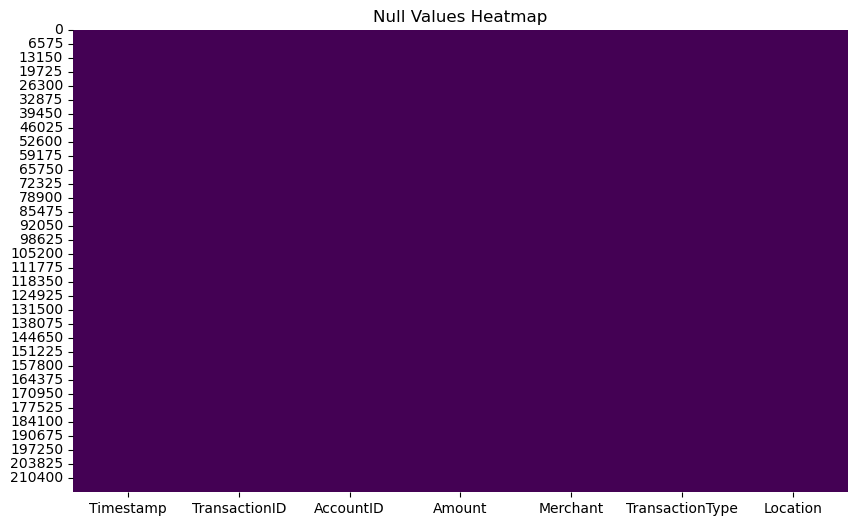

In [7]:
# Visulaize this using Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(null_values, cmap='viridis', cbar=False)
plt.title('Null Values Heatmap')
plt.show()

#### There are no null values in the dataset!

### Counting the unique 'Transaction Type', 'Merchant', 'Account ID', 'Location'.

In [8]:
unique_transactiontype_count = data['TransactionType'].nunique()
unique_transactiontype_count

3

In [9]:
unique_locations_count = data['Location'].nunique()
unique_locations_count

5

In [10]:
unique_merchant_count = data['Merchant'].nunique()
unique_merchant_count

10

In [11]:
unique_account_count = data['AccountID'].nunique()
unique_account_count

15

### Visulazing the Count Plot to understand Imbalances if any

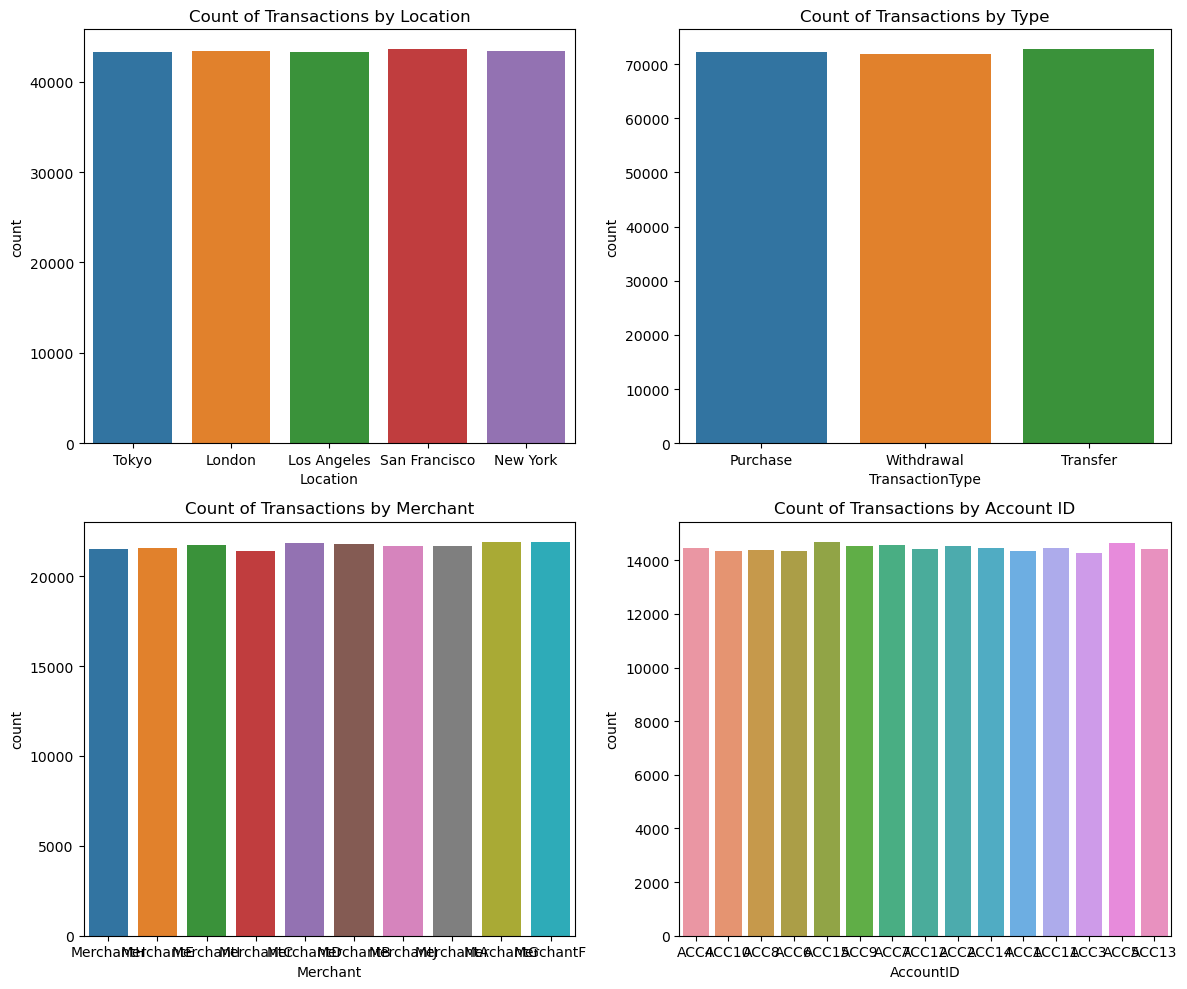

In [12]:
# Set up a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot for 'Location'
sns.countplot(x='Location', data=data, ax=axes[0, 0])
axes[0, 0].set_title('Count of Transactions by Location')

# Plot for 'Transaction Types'
sns.countplot(x='TransactionType', data=data, ax=axes[0, 1])
axes[0, 1].set_title('Count of Transactions by Type')

# Plot for 'Merchant'
sns.countplot(x='Merchant', data=data, ax=axes[1, 0])
axes[1, 0].set_title('Count of Transactions by Merchant')

# Plot for 'Account ID'
sns.countplot(x='AccountID', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Count of Transactions by Account ID')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### From the Graph it doesnt seem to have any Imbalances in any features 

<Axes: xlabel='Location', ylabel='Amount'>

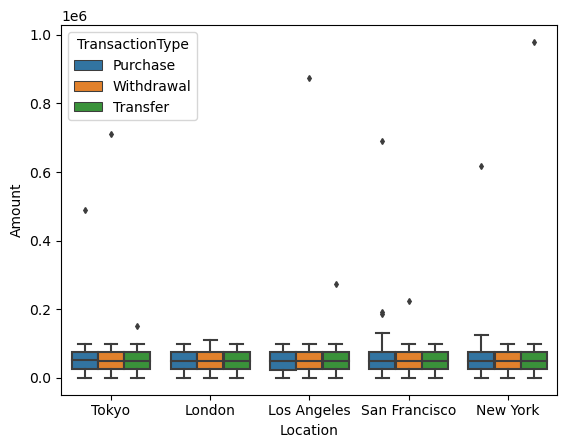

In [13]:
sns.boxplot(data=data, x="Location", y="Amount", hue="TransactionType", fliersize=3)

#### I can see outliers here, but dont know how many any what they are, Implementing model will help me identify them

In [14]:
# Lets understand Transaction IDs
unique_transactionids_count = data['TransactionID'].nunique()
unique_transactionids_count

1999

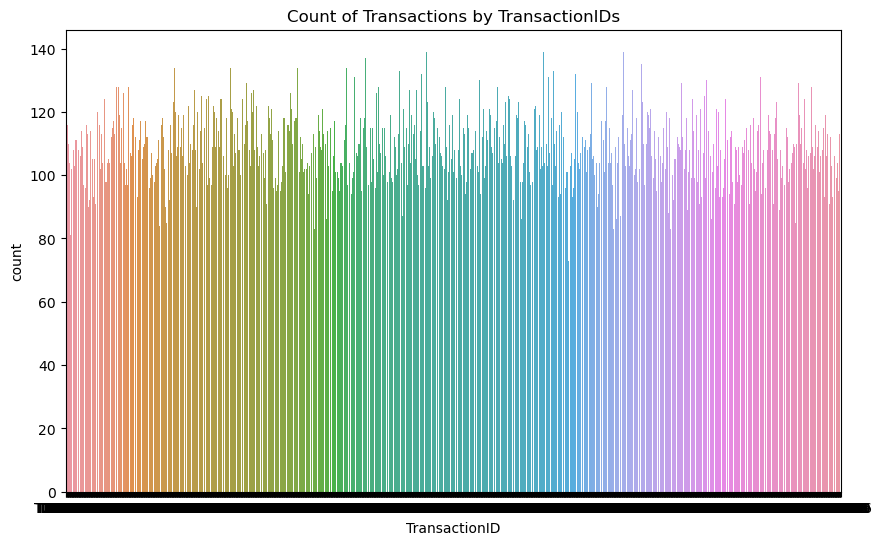

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x='TransactionID', data=data)
plt.title('Count of Transactions by TransactionIDs')
plt.show()

<p>There are various unique values within the Transaction ID, and I had the option to encode it by replacing solely the numerical component, considering that each Transaction ID commences with "TXN" followed by a distinctive number. Nevertheless, given that the numerical aspect of the transaction holds no significance in predicting outcomes and could potentially bias the model, I've made the decision to exclude it from the feature selection process to prevent any unwarranted impact on the model.</p>

## Understanding Dummy Variable Trap

### Now lets encode Transaction Type

In [16]:
# One-Hot Encoding for 'Transaction Type'
transaction_type_dummies = pd.get_dummies(data['TransactionType'], prefix='TransactionType')
transaction_type_dummies = transaction_type_dummies.astype(int)  # Convert boolean to 0s and 1s
data = pd.concat([data, transaction_type_dummies], axis=1)

In [17]:
data.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,TransactionType_Purchase,TransactionType_Transfer,TransactionType_Withdrawal
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,1,0,0
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,1,0,0
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,0,0,1
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London,1,0,0
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,1,0,0


<p>If we have a look at 'TransactionType_Purchase', 'TransactionType_Transfer', 'TransactionType_Withdrawal', in each row, every row has one 1 and 2 0s, having that same for all the rows will can lead to collinearity issues. To solve this issue, we will have to drop one of the newly made colomn, I will drop 'TransactionType_Purchase' </p>

In [18]:
data.drop(columns=['TransactionType_Purchase'], axis=1, inplace=True)

In [19]:
data.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,TransactionType_Transfer,TransactionType_Withdrawal
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,0,0
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,0,0
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,0,1
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London,0,0
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,0,0


### There is a more simple way to do it and I demonstrated it in the below code

In [20]:
# One-Hot Encoding for 'Location'
location_dummies = pd.get_dummies(data['Location'], prefix='Location', drop_first= True)
location_dummies = location_dummies.astype(int)  # Convert boolean to 0s and 1s
data = pd.concat([data, location_dummies], axis=1)

#One-Hot Encoding for 'Account ID'
AccountID_dummies = pd.get_dummies(data['AccountID'], prefix='AccountID', drop_first= True)
AccountID_dummies = AccountID_dummies.astype(int)  # Convert boolean to 0s and 1s
data = pd.concat([data, AccountID_dummies], axis=1)

# One-Hot Encoding for 'Merchant'
Merchant_dummies = pd.get_dummies(data['Merchant'], prefix='Merchant', drop_first= True)
Merchant_dummies = Merchant_dummies.astype(int)  # Convert boolean to 0s and 1s
data = pd.concat([data, Merchant_dummies], axis=1)

In [21]:
data.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,TransactionType_Transfer,TransactionType_Withdrawal,Location_Los Angeles,...,AccountID_ACC9,Merchant_MerchantB,Merchant_MerchantC,Merchant_MerchantD,Merchant_MerchantE,Merchant_MerchantF,Merchant_MerchantG,Merchant_MerchantH,Merchant_MerchantI,Merchant_MerchantJ
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## Dealing with Timestamp

In [22]:
column_data_type = data['Timestamp'].dtype
column_data_type

dtype('O')

In [23]:
# current datatype of the 'Timestamp' column is Object, now lets convert that into Timestamps
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format="%d-%m-%Y %H:%M")

In [24]:
column_data_type = data['Timestamp'].dtype
column_data_type

dtype('<M8[ns]')

In [25]:
# In case of fraud detection, Time and Day of the transaction becomes important, so lets extract time and day from 'Timestamp'.
# Also extracting Month to help solve problem 4
unique_timestamps_count = data['Timestamp'].nunique()
unique_timestamps_count

216960

In [26]:
data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.day_name()
data['Month'] = data['Timestamp'].dt.month

In [27]:
data.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,TransactionType_Transfer,TransactionType_Withdrawal,Location_Los Angeles,...,Merchant_MerchantD,Merchant_MerchantE,Merchant_MerchantF,Merchant_MerchantG,Merchant_MerchantH,Merchant_MerchantI,Merchant_MerchantJ,Hour,DayOfWeek,Month
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,0,0,0,...,0,0,0,0,1,0,0,8,Sunday,1
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,0,0,0,...,0,0,0,0,1,0,0,8,Sunday,1
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,0,1,0,...,0,1,0,0,0,0,0,8,Sunday,1
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London,0,0,0,...,0,1,0,0,0,0,0,8,Sunday,1
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,0,0,1,...,0,0,0,0,0,1,0,8,Sunday,1


In [28]:
unique_Months_count = data['Month'].nunique()
unique_Months_count

5

In [29]:
#seeing what those months are
unique_Months = data['Month'].unique()
unique_Months

array([1, 2, 3, 4, 5])

<p> The given dataset has Months till May, and part 2 is to predit the spend for all Transaction Types for the month of June. I will get back to it later </p>

In [30]:
# Encoding DayOfWeek Using One hot encoding
DayOfWeek_dummies = pd.get_dummies(data['DayOfWeek'], prefix='DayOfWeek', drop_first= True)
DayOfWeek_dummies = DayOfWeek_dummies.astype(int)
data = pd.concat([data, DayOfWeek_dummies], axis=1)

In [31]:
data.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,TransactionType_Transfer,TransactionType_Withdrawal,Location_Los Angeles,...,Merchant_MerchantJ,Hour,DayOfWeek,Month,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,0,0,0,...,0,8,Sunday,1,0,0,1,0,0,0
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,0,0,0,...,0,8,Sunday,1,0,0,1,0,0,0
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,0,1,0,...,0,8,Sunday,1,0,0,1,0,0,0
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London,0,0,0,...,0,8,Sunday,1,0,0,1,0,0,0
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,0,0,1,...,0,8,Sunday,1,0,0,1,0,0,0


### Feature Selection

In [32]:
data.columns

Index(['Timestamp', 'TransactionID', 'AccountID', 'Amount', 'Merchant',
       'TransactionType', 'Location', 'TransactionType_Transfer',
       'TransactionType_Withdrawal', 'Location_Los Angeles',
       'Location_New York', 'Location_San Francisco', 'Location_Tokyo',
       'AccountID_ACC10', 'AccountID_ACC11', 'AccountID_ACC12',
       'AccountID_ACC13', 'AccountID_ACC14', 'AccountID_ACC15',
       'AccountID_ACC2', 'AccountID_ACC3', 'AccountID_ACC4', 'AccountID_ACC5',
       'AccountID_ACC6', 'AccountID_ACC7', 'AccountID_ACC8', 'AccountID_ACC9',
       'Merchant_MerchantB', 'Merchant_MerchantC', 'Merchant_MerchantD',
       'Merchant_MerchantE', 'Merchant_MerchantF', 'Merchant_MerchantG',
       'Merchant_MerchantH', 'Merchant_MerchantI', 'Merchant_MerchantJ',
       'Hour', 'DayOfWeek', 'Month', 'DayOfWeek_Monday', 'DayOfWeek_Saturday',
       'DayOfWeek_Sunday', 'DayOfWeek_Thursday', 'DayOfWeek_Tuesday',
       'DayOfWeek_Wednesday'],
      dtype='object')

In [33]:
features = ['Amount', 'TransactionType_Transfer',
       'TransactionType_Withdrawal', 'Location_Los Angeles',
       'Location_New York', 'Location_San Francisco', 'Location_Tokyo',
       'AccountID_ACC10', 'AccountID_ACC11', 'AccountID_ACC12',
       'AccountID_ACC13', 'AccountID_ACC14', 'AccountID_ACC15',
       'AccountID_ACC2', 'AccountID_ACC3', 'AccountID_ACC4', 'AccountID_ACC5',
       'AccountID_ACC6', 'AccountID_ACC7', 'AccountID_ACC8', 'AccountID_ACC9',
       'Merchant_MerchantB', 'Merchant_MerchantC', 'Merchant_MerchantD',
       'Merchant_MerchantE', 'Merchant_MerchantF', 'Merchant_MerchantG',
       'Merchant_MerchantH', 'Merchant_MerchantI', 'Merchant_MerchantJ',
       'Hour','DayOfWeek_Monday', 'DayOfWeek_Saturday',
       'DayOfWeek_Sunday', 'DayOfWeek_Thursday', 'DayOfWeek_Tuesday',
       'DayOfWeek_Wednesday']

In [34]:
# Create a new DataFrame with only the selected feature columns
final_dataset = data[features].copy()

In [35]:
final_dataset.head()

,Amount,TransactionType_Transfer,TransactionType_Withdrawal,Location_Los Angeles,Location_New York,Location_San Francisco,Location_Tokyo,AccountID_ACC10,AccountID_ACC11,AccountID_ACC12,...,Merchant_MerchantH,Merchant_MerchantI,Merchant_MerchantJ,Hour,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
0,95071.92,0,0,0,0,0,1,0,0,0,...,1,0,0,8,0,0,1,0,0,0
1,15607.89,0,0,0,0,0,0,1,0,0,...,1,0,0,8,0,0,1,0,0,0
2,65092.34,0,1,0,0,0,0,0,0,0,...,0,0,0,8,0,0,1,0,0,0
3,87.87,0,0,0,0,0,0,0,0,0,...,0,0,0,8,0,0,1,0,0,0
4,716.56,0,0,1,0,0,0,0,0,0,...,0,1,0,8,0,0,1,0,0,0


In [36]:
final_dataset.shape

(216960, 37)

# Model

In [37]:
from sklearn.ensemble import IsolationForest


# Initialize the Isolation Forest model
model = IsolationForest(contamination='auto', n_estimators= 65, random_state=42)
# Fit the model on your data
model.fit(final_dataset)

# Predict outliers (1 for inliers, -1 for outliers)
predictions = model.predict(final_dataset)

# Extract the indices of outliers
outlier_indices = np.where(predictions == -1)[0]

# Print the indices of outliers
print("Indices of outliers:", outlier_indices)

Indices of outliers: [  2290   5321   5342   5390   5392   5985   6375   6394   6627   6641
  12074  12362  15385  15393  15399  15404  15411  15453  16135  16650
  16723  16799  18256  21170  21806  22540  25482  25535  25663  25700
  25904  26197  26363  26622  26715  26787  26842  31276  31282  31410
  31443  31533  32359  35521  35547  35780  35829  35917  36779  36821
  36857  36905  41656  41722  45640  45642  45652  45714  46152  46231
  46740  46765  46849  46985  55868  56262  56629  56865  57056  57100
  57114  61516  61759  61982  62194  65876  66039  66178  66945  67132
  67136  67142  67177  70129  70683  71131  71424  71735  72059  75792
  75861  75876  75894  75917  77032  77094  77165  77186  77198  77261
  81724  82251  85944  85969  86032  86126  87088  87198  87209  87274
  91738  92056  96031  96240  96354  97289  97336  97409  97426  97427
  97428  98926 100314 101153 101841 106112 106597 106680 106724 106924
 107252 107342 107377 107468 112052 112646 116182 116188

In [38]:
len(outlier_indices)

266

In [39]:
outlier_data_points = data[['Timestamp', 'TransactionID', 'AccountID', 'Amount', 'Merchant','TransactionType', 'Location']].iloc[outlier_indices]

In [40]:
outlier_data_points.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
2290,2023-01-02 22:10:00,TXN854,ACC10,5583.00,MerchantG,Withdrawal,Tokyo
5321,2023-01-05 00:41:00,TXN1997,ACC10,88670.20,MerchantJ,Withdrawal,Los Angeles
5342,2023-01-05 01:02:00,TXN583,ACC6,13297.52,MerchantJ,Transfer,Los Angeles
5390,2023-01-05 01:50:00,TXN40,ACC2,72856.97,MerchantI,Withdrawal,Los Angeles
5392,2023-01-05 01:52:00,TXN1334,ACC3,201.55,MerchantI,Withdrawal,New York


In [41]:
outlier_data_points.describe()

,Timestamp,Amount
count,266,266.000000
mean,2023-03-16 21:28:50.977443840,41356.997218
min,2023-01-02 22:10:00,26.350000
25%,2023-02-09 16:48:00,7036.782500
50%,2023-03-16 22:22:30,30218.520000
75%,2023-04-26 03:13:45,79740.737500
max,2023-05-29 20:48:00,99747.440000
std,NaN,35548.989875
